# Sample Code

## 基礎建設

In [84]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [85]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-30 01:22:30--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.1’

All_Beauty.csv.1    100%[===================>]  14.78M  20.1MB/s    in 0.7s    

2021-12-30 01:22:31 (20.1 MB/s) - ‘All_Beauty.csv.1’ saved [15499476/15499476]

--2021-12-30 01:22:31--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.85M  15.1MB/s    in 0.7s   

In [86]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [87]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [88]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.000,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.000,1418860800
2,0143026860,A1572GUYS7DGSR,4.000,1407628800
3,0143026860,A1PSGLFK1NSVO,5.000,1362960000
4,0143026860,A6IKXKZMTKGSC,5.000,1324771200


## 清理資料

In [89]:
metadata_clean = metadata.drop_duplicates('asin')
print(f'Original size: {len(metadata)}, modify: {len(metadata_clean)}')


Original size: 32892, modify: 32488


In [90]:
# title/ rank string clean
print("rank not str Number:",len(metadata_clean["rank"][metadata_clean['rank'].apply(lambda x: type(x)!=str)]))
print("title not str Number:",len(metadata_clean["title"][metadata_clean['title'].apply(lambda x: type(x)!=str)]))

rank not str Number: 402
title not str Number: 0


In [91]:
metadata_clean["rank"] = metadata_clean["rank"].apply(lambda x: x if type(x) == str else "999999999999 in None")
metadata_clean["title"] = metadata_clean["title"].apply(lambda x: x if type(x) == str else "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 資料整理



1. 將metadata重複asin的清除
2. category目前的項目都是空的
3. 若用rank後的資料分類，有404項為無分類
4. 每個種類的成交數量都明顯下降，感覺公司要倒了...
5. Beauty & Personal Care與None是相對較多購買量的商品種類



### 初步抓出rank/sub_category

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [93]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [94]:
# ranking setting
metadata_clean.loc[:,'ranking'] = metadata_clean.loc[:,'rank'].str.split(expand = True)[0]
metadata_clean.loc[:,'ranking'] = metadata_clean.loc[:,'ranking'].str.replace(',', '')
metadata_clean.loc[:,'ranking'] = pd.to_numeric(metadata_clean.loc[:,'ranking'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [95]:
# category check
number = len(metadata_clean['category'][metadata_clean['category'].apply(lambda x: len(x)) > 0])
print(f'There are {number} catagory having data.')

There are 0 catagory having data.


In [96]:
metadata_clean["sub_category"] = metadata_clean["rank"].str.split("in ").str[1].replace(r"\(","", regex=True).replace(r"\&amp;","&", regex=True)
metadata_clean["sub_category"].value_counts().rename_axis('name').reset_index(name='counts')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,counts
0,Beauty & Personal Care,32015
1,None,402
2,Grocery & Gourmet Food,37
3,Health & Household,21
4,Sports & Outdoors,3
5,Toys & Games,3
6,"Clothing, Shoes & Jewelry",2
7,Baby,2
8,Home & Kitchen,1
9,Tools & Home Improvement,1


### 對sub_category與時間作分析
--> 公司購買各種類的數量明顯下降... (公司危機!!)

In [116]:
metadata_clean[metadata_clean["sub_category"]=="None"].head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,ranking,sub_category,text_data,specify
36,[],,[<P><STRONG>Helps Reduce Appearance Of Hair Gr...,,Nair Hair Remover 4 Minute Lotion with Aloe &a...,[],,nair,[],999999999999 in None,[],"{'Shipping Weight:': '6.4 ounces', 'ASIN: ': '...",All Beauty,,,,B000052WYR,[],[],999999999999,None,nair hair remov 4 minut lotion alo amp lanolin...,6.000
38,[],,[Scope Original Mint Rinse kills bad breath ge...,,Scope Original Mint Mouthwash 50.7 Fl Oz,"[B009LNU6ME, B00L1I1VYY, B00J5K0QEQ, B0035U184...",,Unknown,[],999999999999 in None,"[B009LNU6ME, B007CRIFSS, B074KHNR82, B01FVAYP8...",{' Product Dimensions: ': '5.1 x 3.7 ...,All Beauty,,,,B000052YD8,[],[],999999999999,None,scope origin mint mouthwash 507 fl oz scope or...,6.000
43,[],,[Using this is like chumming the air for prett...,,Old Spice High Endurance Anti-Perspirant &amp;...,[],,Old Spice,[],999999999999 in None,"[B006Y3JDH8, B01I9THZKQ, B07CPFGVM3, B0014CU2U...",{' Product Dimensions: ': '5 x 2.1 x ...,All Beauty,,,$5.21,B00005308B,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,999999999999,None,old spice high endur antiperspir amp deodor or...,4.000
46,[],,[Naturally comfort your skin with this St. Ive...,,St. Ives Advanced Therapy Lotion for Extra Dry...,[],,St. Ives,[],999999999999 in None,[],{' Product Dimensions: ': '8.7 x 3.4 ...,All Beauty,,,,B0000530ND,[],[],999999999999,None,st ive advanc therapi lotion extra dri skin al...,6.000
54,[],,"[, <strong>Platinum Protection is the best dry...",,Secret Platinum Protection Antiperspirant &amp...,[],,Secret,[],999999999999 in None,[],"{'Shipping Weight:': '4.8 ounces', 'Domestic S...",All Beauty,,,,B00005354G,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,999999999999,None,secret platinum protect antiperspir amp deodor...,7.000


In [117]:
def historyCounts(start, end, biastime):
  current = start
  output = []
  index = {name: i for i, name in enumerate(np.unique(metadata_clean["sub_category"]))}
  while current < end:
    tmp = [0]*len(index)
    currentTime = current.strftime("%Y-%m-%d")
    nextTime = (current+biastime).strftime("%Y-%m-%d")
    print(f'{currentTime} -> {nextTime}')
    tmpdata = ratings[(ratings['DATE'] >= currentTime) & (ratings['DATE'] < nextTime)]
    for item, row in tmpdata.iterrows():
      asin = row['asin']
      sub_category = metadata_clean[metadata_clean["asin"]==asin]
      if len(sub_category) > 0:
        sub_category = sub_category["sub_category"].iloc[0]
        tmp[index[sub_category]] += 1
    output.append(tmp)
    current = current + biastime
  return output

output = historyCounts(datetime(2017,1,1), datetime(2018,10,1), relativedelta(months=1))

'''
output =
[[2, 0, 8496, 0, 10, 7, 0, 97, 5, 0, 0],
 [0, 0, 6453, 0, 6, 3, 0, 75, 0, 0, 0],
 [0, 0, 7401, 2, 6, 5, 0, 44, 0, 0, 1],
 [1, 0, 5979, 0, 6, 3, 0, 54, 1, 0, 1],
 [1, 0, 5565, 0, 4, 4, 0, 58, 0, 1, 0],
 [0, 1, 5192, 0, 6, 1, 0, 59, 0, 0, 0],
 [1, 0, 5330, 0, 4, 2, 0, 29, 0, 1, 0],
 [0, 0, 5892, 1, 3, 0, 0, 46, 0, 0, 1],
 [0, 0, 5865, 1, 5, 0, 1, 44, 0, 0, 0],
 [0, 0, 4587, 0, 2, 1, 0, 50, 0, 1, 0],
 [1, 0, 4142, 0, 8, 0, 0, 34, 0, 0, 1],
 [1, 0, 3893, 0, 2, 0, 0, 68, 1, 0, 0],
 [0, 0, 4766, 0, 3, 0, 0, 66, 0, 0, 0],
 [0, 0, 4389, 0, 4, 5, 0, 45, 0, 1, 2],
 [0, 0, 4869, 0, 5, 12, 0, 49, 0, 0, 0],
 [1, 0, 4542, 0, 9, 12, 0, 49, 0, 1, 0],
 [0, 0, 3749, 1, 5, 5, 0, 29, 0, 0, 1],
 [0, 0, 2936, 0, 7, 6, 0, 25, 1, 1, 0],
 [1, 0, 2347, 0, 3, 12, 0, 22, 1, 1, 0],
 [0, 0, 1644, 0, 6, 1, 0, 11, 0, 0, 0],
 [2, 0, 584, 0, 1, 1, 0, 2, 0, 0, 0]]
'''

2017-01-01 -> 2017-02-01
2017-02-01 -> 2017-03-01
2017-03-01 -> 2017-04-01
2017-04-01 -> 2017-05-01
2017-05-01 -> 2017-06-01
2017-06-01 -> 2017-07-01
2017-07-01 -> 2017-08-01
2017-08-01 -> 2017-09-01
2017-09-01 -> 2017-10-01
2017-10-01 -> 2017-11-01
2017-11-01 -> 2017-12-01
2017-12-01 -> 2018-01-01
2018-01-01 -> 2018-02-01
2018-02-01 -> 2018-03-01
2018-03-01 -> 2018-04-01
2018-04-01 -> 2018-05-01
2018-05-01 -> 2018-06-01
2018-06-01 -> 2018-07-01
2018-07-01 -> 2018-08-01
2018-08-01 -> 2018-09-01
2018-09-01 -> 2018-10-01


'\noutput =\n[[2, 0, 8496, 0, 10, 7, 0, 97, 5, 0, 0],\n [0, 0, 6453, 0, 6, 3, 0, 75, 0, 0, 0],\n [0, 0, 7401, 2, 6, 5, 0, 44, 0, 0, 1],\n [1, 0, 5979, 0, 6, 3, 0, 54, 1, 0, 1],\n [1, 0, 5565, 0, 4, 4, 0, 58, 0, 1, 0],\n [0, 1, 5192, 0, 6, 1, 0, 59, 0, 0, 0],\n [1, 0, 5330, 0, 4, 2, 0, 29, 0, 1, 0],\n [0, 0, 5892, 1, 3, 0, 0, 46, 0, 0, 1],\n [0, 0, 5865, 1, 5, 0, 1, 44, 0, 0, 0],\n [0, 0, 4587, 0, 2, 1, 0, 50, 0, 1, 0],\n [1, 0, 4142, 0, 8, 0, 0, 34, 0, 0, 1],\n [1, 0, 3893, 0, 2, 0, 0, 68, 1, 0, 0],\n [0, 0, 4766, 0, 3, 0, 0, 66, 0, 0, 0],\n [0, 0, 4389, 0, 4, 5, 0, 45, 0, 1, 2],\n [0, 0, 4869, 0, 5, 12, 0, 49, 0, 0, 0],\n [1, 0, 4542, 0, 9, 12, 0, 49, 0, 1, 0],\n [0, 0, 3749, 1, 5, 5, 0, 29, 0, 0, 1],\n [0, 0, 2936, 0, 7, 6, 0, 25, 1, 1, 0],\n [1, 0, 2347, 0, 3, 12, 0, 22, 1, 1, 0],\n [0, 0, 1644, 0, 6, 1, 0, 11, 0, 0, 0],\n [2, 0, 584, 0, 1, 1, 0, 2, 0, 0, 0]]\n'

In [118]:
def historyTimestep(start, end, biastime):
  timestep = []
  current = start
  while current < end:
    currentTime = current.strftime("%Y-%m-%d")
    timestep.append(currentTime)
    current = current + biastime
  return timestep

sub_category_Counts = pd.DataFrame(output, columns=np.unique(metadata_clean["sub_category"]))
sub_category_Counts.index = historyTimestep(datetime(2017,1,1), datetime(2018,10,1), relativedelta(months=1))
sub_category_Counts

,Automotive,Baby,Beauty & Personal Care,"Clothing, Shoes & Jewelry",Grocery & Gourmet Food,Health & Household,Home & Kitchen,None,Sports & Outdoors,Tools & Home Improvement,Toys & Games
2017-01-01,2,0,8496,0,10,7,0,97,5,0,0
2017-02-01,0,0,6453,0,6,3,0,75,0,0,0
2017-03-01,0,0,7401,2,6,5,0,44,0,0,1
2017-04-01,1,0,5979,0,6,3,0,54,1,0,1
2017-05-01,1,0,5565,0,4,4,0,58,0,1,0
2017-06-01,0,1,5192,0,6,1,0,59,0,0,0
2017-07-01,1,0,5330,0,4,2,0,29,0,1,0
2017-08-01,0,0,5892,1,3,0,0,46,0,0,1
2017-09-01,0,0,5865,1,5,0,1,44,0,0,0
2017-10-01,0,0,4587,0,2,1,0,50,0,1,0


#############===
Automotive 


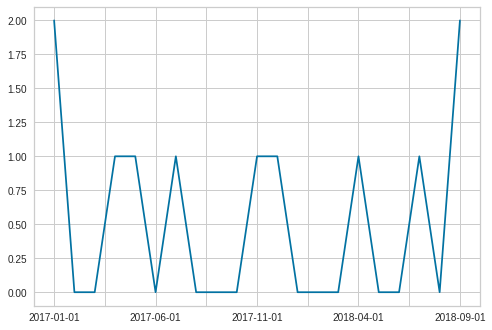


#############===
Baby 


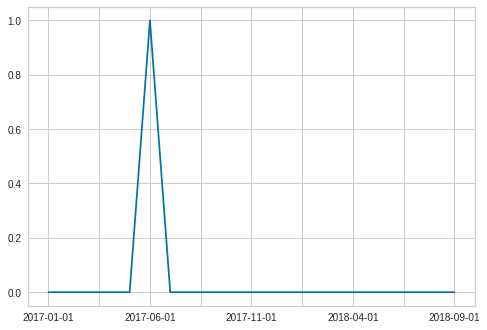


#############===
Beauty & Personal Care 


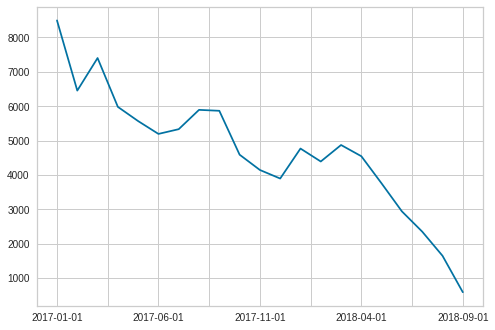


#############===
Clothing, Shoes & Jewelry 


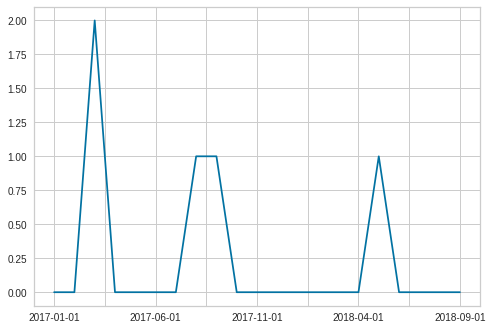


#############===
Grocery & Gourmet Food 


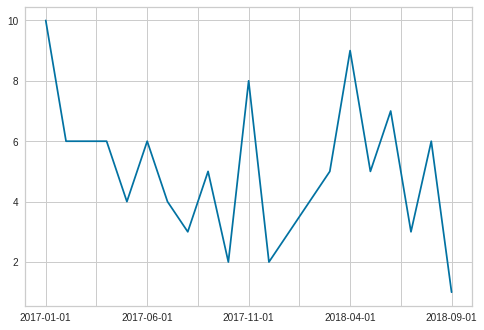


#############===
Health & Household 


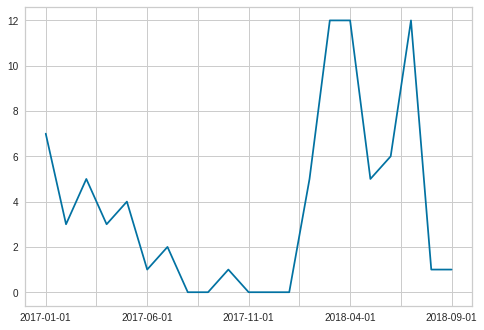


#############===
Home & Kitchen 


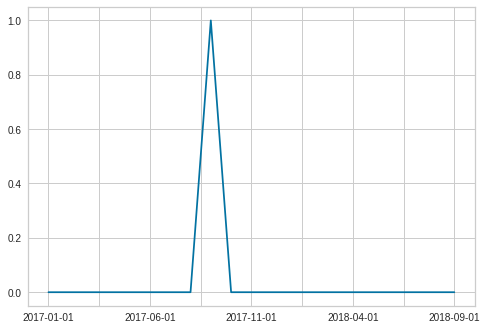


#############===
None


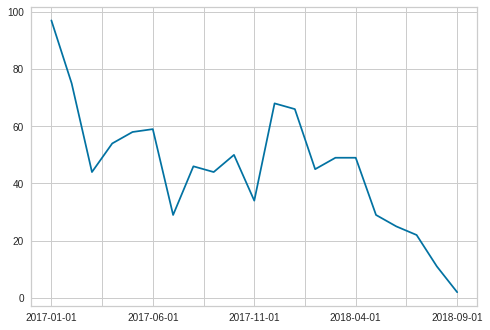


#############===
Sports & Outdoors 


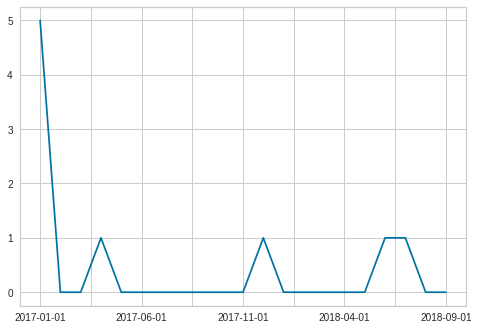


#############===
Tools & Home Improvement 


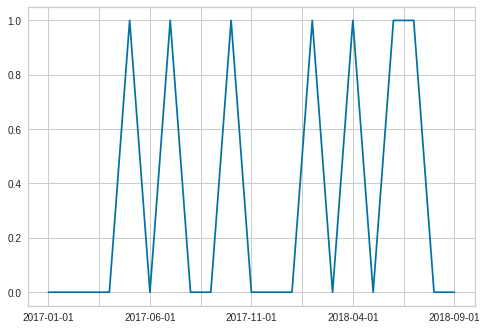


#############===
Toys & Games 


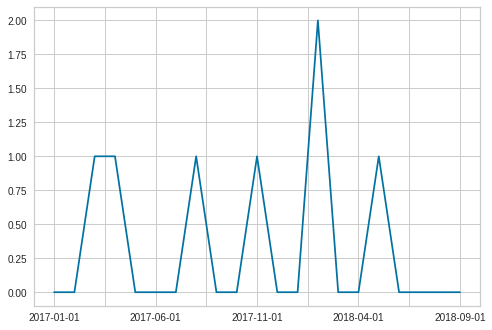

In [119]:
for column in sub_category_Counts.columns:
  print("#############===")
  print(column)
  sub_category_Counts[column].plot()
  plt.show()
  print()

## 資料切分

In [46]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## 價格分析

In [97]:
metadata_clean.loc[:,'priceNumber'] = metadata_clean["price"].str.split("$",expand = True)[1]
metadata_clean.loc[:,'priceNumber'] = metadata_clean["priceNumber"].str.split(expand = True)[0]
metadata_clean.loc[:,'priceNumber'] = metadata_clean.loc[:,'priceNumber'].str.replace(',', '')
metadata_clean.loc[:,'priceNumber'] = pd.to_numeric(metadata_clean.loc[:,'priceNumber'])

metadata_clean.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,ranking,sub_category,priceNumber
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[],2938573,Beauty & Personal Care,nan
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[],872854,Beauty & Personal Care,44.990
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[],956696,Beauty & Personal Care,28.760
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,1870258,Beauty & Personal Care,nan
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,67701,Beauty & Personal Care,12.150


2149.0    0.01
32488
384


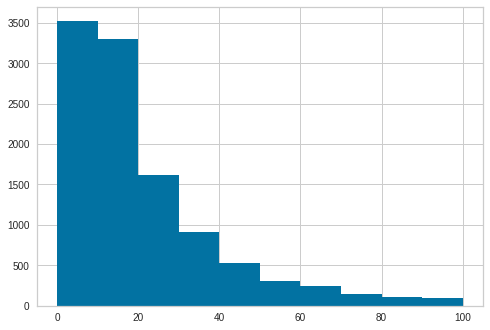

In [98]:
print(metadata_clean["priceNumber"].max(), "  ", metadata_clean["priceNumber"].min())
print(len(metadata_clean))
print(sum(metadata_clean["priceNumber"] > 100))
metadata_clean["priceNumber"][metadata_clean["priceNumber"] < 100].hist()

In [99]:
metadata_clean.loc[:,"priceGroup"] = 0
metadata_clean.loc[:,"priceGroup"][metadata_clean["priceNumber"]>=20] = 1
metadata_clean.loc[:,"priceGroup"][metadata_clean["priceNumber"]>=40] = 2
metadata_clean.loc[:,"priceGroup"][metadata_clean["priceNumber"]>=60] = 3
metadata_clean.loc[:,"priceGroup"][metadata_clean["priceNumber"].isnull()] = 4
print(metadata_clean["priceGroup"].value_counts())
metadata_clean.head()

4    21313
0     6775
1     2553
3      990
2      857
Name: priceGroup, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,ranking,sub_category,priceNumber,priceGroup
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[],2938573,Beauty & Personal Care,nan,4
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[],872854,Beauty & Personal Care,44.990,2
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[],956696,Beauty & Personal Care,28.760,1
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,1870258,Beauty & Personal Care,nan,4
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,67701,Beauty & Personal Care,12.150,0


## 標題（Title）TF-IDF分析

In [100]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import math
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.porter import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
def get_tokens(text):
  lowers = text.lower()
  #remove the punctuation using the character deletion step of translate
  remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
  no_punctuation = lowers.translate(remove_punctuation_map)
  tokens = nltk.word_tokenize(no_punctuation)
  return tokens

def stem_tokens(tokens, stemmer):
  stemmed = []
  for item in tokens:
    stemmed.append(stemmer.stem(item))
  return stemmed

def filterTXTnoisy(txt):
  tokens = get_tokens(txt)
  filtered = [w for w in tokens if not w in stopwords.words('english')]
  stemmer = PorterStemmer()
  return " ".join(stem_tokens(filtered, stemmer))

In [102]:
def extractTXT(x):
  txt = f'{x["title"]}, {" ".join(x["description"])}'
  txt = txt.replace(r"\&amp;","&")
  return filterTXTnoisy(txt)

metadata_clean['text_data'] = metadata_clean.agg(extractTXT, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
text = metadata_clean['text_data'].tolist()
vectorizor = TfidfVectorizer(min_df=200)
for idx, value in enumerate(text):
    if not isinstance(value, str):
        text[idx] = ''
feature = vectorizor.fit_transform(text).toarray()
len(vectorizor.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


739

In [114]:
n_clusters=60
model = AgglomerativeClustering(n_clusters=n_clusters)
result = model.fit_predict(feature)

In [129]:
metadata_clean['specify'] = pd.Series(result)
metadata_clean.to_csv('/content/wordFilter_60group_price.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [130]:
metadata_clean['specify'].value_counts()

29.000    7919
28.000    4730
1.000     1485
4.000     1448
2.000      796
7.000      734
19.000     672
9.000      582
23.000     535
41.000     513
31.000     481
36.000     422
10.000     404
47.000     399
40.000     385
18.000     383
35.000     379
17.000     369
53.000     367
25.000     355
12.000     353
8.000      348
6.000      329
26.000     300
14.000     297
50.000     296
24.000     290
3.000      284
15.000     279
21.000     265
11.000     262
51.000     261
55.000     251
58.000     251
56.000     251
16.000     244
49.000     233
33.000     219
59.000     217
5.000      216
13.000     214
52.000     210
22.000     209
0.000      205
38.000     201
30.000     197
27.000     197
42.000     192
37.000     174
32.000     169
57.000     167
39.000     157
54.000     152
34.000     141
20.000     133
44.000     131
46.000     124
43.000     119
45.000     118
48.000      70
Name: specify, dtype: int64

In [132]:
def transform(data):
  res = dict()
  for item, row in data.iterrows():
    res[row['asin']] = row['specify']
  return res
cluster_dict = transform(metadata_clean)


In [134]:
def construct(data):
  if cluster_dict.get(data):
    return cluster_dict[data]
  else:
    return n_clusters+2
ratings['cluster'] = ratings['asin'].apply(construct)

In [135]:
ratings['cluster'].value_counts()

29.000    95313
28.000    64944
1.000     25541
4.000     12271
23.000     8247
2.000      7778
7.000      7548
62.000     6957
6.000      6395
19.000     5915
9.000      5646
36.000     4950
3.000      4321
41.000     4315
50.000     4314
35.000     4273
17.000     4265
53.000     4202
47.000     4130
31.000     4088
43.000     4033
10.000     3937
12.000     3747
30.000     3468
18.000     3325
40.000     3312
59.000     3110
26.000     3069
8.000      2835
51.000     2794
15.000     2773
52.000     2573
21.000     2475
25.000     2420
13.000     2413
46.000     2406
14.000     2236
16.000     2149
24.000     2105
11.000     2097
34.000     1956
33.000     1903
49.000     1801
56.000     1715
5.000      1632
55.000     1580
22.000     1558
42.000     1524
58.000     1497
39.000     1467
44.000     1436
27.000     1420
57.000     1303
37.000     1165
38.000      948
32.000      885
45.000      643
54.000      615
20.000      597
48.000      429
Name: cluster, dtype: int64

## 測試

In [188]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
  '''
  * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
  * ratings_by_user: dict 利用訓練資料學習的推薦商品
  * method: str
  * score: float
  '''
  total = 0
  for d in ratings_testings_by_user:
      if d in ratings_by_user:
          total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

  score = total / len(ratings_testings)
  return score

def recommender(training_data, group, time, users=[], k=10):
  if group > n_clusters-1:
    group = n_clusters+2
  target = training_data[(training_data['cluster'] == group)&
                (training_data['DATE']>=time) &
                #((training_data['DATE']>=time) | ((training_data['DATE']>='2017-09-01') & (training_data['DATE']<='2017-09-30'))) &
                (training_data['overall']>=training_data['overall'].mean())
                ]
  filter_training_data = training_data[(training_data['DATE']>=time) | ((training_data['DATE']>='2017-09-01') & (training_data['DATE']<='2017-09-30'))]
  #brand_2 = target['asin'].value_counts().sort_values(ascending=False).keys()[:k]
  brand_2 = target['asin'].value_counts().sort_values(ascending=False).keys()
  brand_3 = []
  for asin in brand_2:
    tmp = metadata_clean[metadata_clean["asin"]==asin]
    if len(tmp) > 0:
      if tmp["priceGroup"].iloc[0] in [2]: continue
      if tmp["sub_category"].iloc[0].strip() != "Beauty & Personal Care": continue
      if filter_training_data[filter_training_data["asin"]==asin]["overall"].quantile(.6) != 5: continue
      brand_3.append(asin)
      if len(brand_3) >= k: break
  recommendations = {user: brand_3 for user in users}
  return recommendations

def create_data(start, end):
  ratings_trainings = ratings[ 
      (ratings['DATE'] <  start)
  ]
  ratings_testings = ratings[
      (ratings['DATE'] >= start) & 
      (ratings['DATE'] <= end)
  ]
  ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
  ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
  users = list(ratings_testings_by_user.keys())
  return ratings_trainings, ratings_testings, ratings_testings_by_user, users

In [189]:
# time_list = ['2018-07-01','2018-05-01', '2018-01-01', '2016-01-01']
time_period_list = [1, 2, 4, 6, 12]
verify_periods = [['2018-09-01', '2018-09-30'],
          ['2018-08-01', '2018-08-30'],
          ['2017-09-01', '2017-09-30']]

score_list = []
index = []
for start, end in verify_periods:
  y,m,d = np.int32(start.split("-"))
  for period in time_period_list:
    trainStart = (datetime(y,m,d)-relativedelta(months=period)).strftime("%Y-%m-%d")
    print([trainStart, start, end])
    index.append("/".join([start, end, str(period)]))
    ratings_trainings, ratings_testings, ratings_testings_by_user, users = create_data(start, end)
    tmp = list()
    for i in [29]: #range(n_clusters+1):
      ratings_by_user = recommender(ratings_trainings, i, trainStart, users)
      score = evaluate(ratings_testings_by_user, ratings_by_user)
      tmp.append(score)
    score_list.append(tmp)


['2018-08-01', '2018-09-01', '2018-09-30']
['2018-07-01', '2018-09-01', '2018-09-30']
['2018-05-01', '2018-09-01', '2018-09-30']
['2018-03-01', '2018-09-01', '2018-09-30']
['2017-09-01', '2018-09-01', '2018-09-30']
['2018-07-01', '2018-08-01', '2018-08-30']
['2018-06-01', '2018-08-01', '2018-08-30']
['2018-04-01', '2018-08-01', '2018-08-30']
['2018-02-01', '2018-08-01', '2018-08-30']
['2017-08-01', '2018-08-01', '2018-08-30']
['2017-08-01', '2017-09-01', '2017-09-30']
['2017-07-01', '2017-09-01', '2017-09-30']
['2017-05-01', '2017-09-01', '2017-09-30']
['2017-03-01', '2017-09-01', '2017-09-30']
['2016-09-01', '2017-09-01', '2017-09-30']


In [190]:
pd.options.display.float_format = '{:,.3f}'.format
table = pd.DataFrame(score_list, index=index)
table

,0
2018-09-01/2018-09-30/1,0.141
2018-09-01/2018-09-30/2,0.139
2018-09-01/2018-09-30/4,0.131
2018-09-01/2018-09-30/6,0.098
2018-09-01/2018-09-30/12,0.098
2018-08-01/2018-08-30/1,0.094
2018-08-01/2018-08-30/2,0.097
2018-08-01/2018-08-30/4,0.068
2018-08-01/2018-08-30/6,0.067
2018-08-01/2018-08-30/12,0.067


## 其他紀錄

### AC課程TF IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 計算商品用標題所表示的 tfidf 矩陣
df = metadata_clean.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title'])

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
mapping = pd.Series(df.index,index = df['title'])
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

In [ ]:
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [ ]:
recommend_items(items=["Loud 'N Clear&trade; Personal Sound Amplifier"], k=10)

['6546546450',
 'B002W3172S',
 'B001FT5DMU',
 'B008L2UR66',
 'B00WUUW18W',
 'B00QUAL0BW',
 'B01G689TOC',
 'B00DG53QSE',
 'B00632SBHS',
 'B00C69IXIY']

In [ ]:
for asin in recommend_items(items=["Loud 'N Clear&trade; Personal Sound Amplifier"], k=10):
  print(asin," : ",metadata[metadata["asin"]==asin]["title"].values)

6546546450  :  ["Loud 'N Clear&trade; Personal Sound Amplifier"]
B002W3172S  :  ['Super Loud Air Horn (2 oz)']
B001FT5DMU  :  ['Juice Organics Lip Amplifier - 0.5 oz.']
B008L2UR66  :  ['Dove Mousse Nourishing Amplifier 7 (Pack of 3)']
B00WUUW18W  :  ["Bare Escentuals bareMinerals 'Loud &amp; Clear' Lip Sheer (1.9 g) - Unboxed - Magenta Vibe"]
B00QUAL0BW  :  ['bareMinerals Loud &amp; Clear Lip Duo - Amped Pink/Tangerine Trance']
B01G689TOC  :  ['Bare Minerals Loud and Clear Lip Sheer Pink Pulse 0.07oz in retail box']
B00DG53QSE  :  ['In Line Amplifier Tone Control 40Db']
B00632SBHS  :  ['Prive Shining Weightless Amplifier 6.8 oz (Pack of 2)']
B00C69IXIY  :  ['Safe and Sound Lockable Safety Pill Cutter']
